In [1]:
import os
import sys
import json
import itertools
import sklearn
import re
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neural_network
from sklearn import svm
from scipy.stats import norm
from sklearn.metrics import confusion_matrix,roc_curve,auc
import random
import numpy as np
import pandas as pd
import math
import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.optimize import curve_fit

In [2]:

#### INPUTS
path_to_predictor_runs_sc = "<path/to/your/second_round>/predictor_runs_combined.sc"
path_to_pilot_runs_sc = "<path/to/your/second_round>/pilot_runs.sc"

path_to_predictor_term_dist_sc = "<path/to/your/second_round>/pred_term_dist.sc"
path_to_pilot_term_dist_sc = "<path/to/your/second_round>/pilot_term_dist.sc"


In [3]:

converters = {'SCORE:':lambda x: x, 'description':lambda x: x}

predictor_df = pd.read_csv(path_to_predictor_runs_sc, sep="\s+", dtype=float, converters=converters)
pred_term_dist_df = pd.read_csv(path_to_predictor_term_dist_sc, sep="\s+", dtype=float, converters=converters)
pred_term_dist_df['description'] = pred_term_dist_df['description'].map(lambda x: x+'_0001')
predictor_df = predictor_df.merge(pred_term_dist_df,'inner','description')

pilot_df = pd.read_csv(path_to_pilot_runs_sc, sep="\s+", dtype=float, converters=converters)
print(len(pilot_df))
pilot_term_dist_df = pd.read_csv(path_to_pilot_term_dist_sc, sep="\s+", dtype=float, converters=converters)
pilot_df = pilot_df.merge(pilot_term_dist_df,'inner','description')

print(len(pilot_df))

predictor_df = predictor_df[predictor_df['ddg_norepack'] <= 20]
predictor_df = predictor_df[predictor_df['score_per_res'] <= 0]
pilot_df = pilot_df[pilot_df['ddg'] <= 20]
pilot_df = pilot_df[pilot_df['score_per_res'] <= 0]

print(len(pilot_df))


def suffix_all_columns(df, suffix):
    cols = list(df.columns)
    for i in range(len(cols)):
        cols[i] = cols[i] + suffix
    df.columns = cols 
    
suffix_all_columns(predictor_df, "_pred")
predictor_df['description'] = predictor_df['description_pred']


pilot_df = pilot_df.merge(predictor_df, 'inner', 'description')

print("Length of predictor dataframe: ", len(predictor_df))
print("Length of pilot dataframe: ", len(pilot_df))

/home/wlwhite/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Both a converter and dtype were specified for column SCORE: - only the converter will be used
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wlwhite/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Both a converter and dtype were specified for column description - only the converter will be used
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wlwhite/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Both a converter and dtype were specified for column SCORE: - only the converter will be used
  after removing the cwd from sys.path.
/home/wlwhite/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Both a converter and dtype were specified for column description - only the converter will be used
  after removing the cwd from sys.path.
/home/wlwhite/

2000
2000
1998
Length of predictor dataframe:  1402377
Length of pilot dataframe:  1994


In [8]:
# The format here is:
# Name of the score in pilot, cut value, higher better, name in predictor, is integer score-term

terms_and_cuts = {
#     'interface_buried_sasa':    [1400,  True,    "interface_buried_sasa_pred", False],
    'ddg':                      [ -43, False,             "ddg_norepack_pred", False], #recommended -40 or top 50%
    'score_per_res' :           [-2.8, False,            "score_per_res_pred", False], #recommended -2.4
#     'fa_atr_pocket':            [-5,  False,            "fa_atr_pocket_pred", False],
    'mismatch_probability':     [0.07,  False,     "mismatch_probability_pred", False], #recommended 0.1
    'contact_molecular_surface':[520,   True,"contact_molecular_surface_pred", False], #recommended 450
    'contact_patch':            [265,   True,            "contact_patch_pred", False], #recommended: 5% pass rate
    'term_dist':                [23,    False,               "term_dist_pred", False]
}


score_df = pilot_df

# Filter all the terms and print the thresholds
ok_terms = []
for pilot_term in terms_and_cuts:
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    ok_term = pilot_term.replace("_pilot", "") + "_ok"
    if ( good_high ):
        score_df[ok_term] = score_df[pilot_term] >= cut
    else:
        score_df[ok_term] = score_df[pilot_term] <= cut
    
    ok_terms.append(ok_term)
    
    print("%30s: %6.2f"%(pilot_term, cut))

# Print the pass rates for each term
print("")
score_df['orderable'] = True
for ok_term in ok_terms:
    score_df['orderable'] &= score_df[ok_term]
    print("%30s: %5.0f%% pass-rate"%(ok_term.replace("_ok", ""), score_df[ok_term].sum() / len(score_df) * 100))

 
# print the overall pass rate   
subdf = score_df
print("Orderable: %i   -- %.2f%%"%(subdf['orderable'].sum(), (100*subdf['orderable'].sum() / len(subdf))))

                           ddg: -43.00
                 score_per_res:  -2.80
          mismatch_probability:   0.07
     contact_molecular_surface: 520.00
                 contact_patch: 265.00
                     term_dist:  23.00

                           ddg:    12% pass-rate
                 score_per_res:     8% pass-rate
          mismatch_probability:    56% pass-rate
     contact_molecular_surface:    11% pass-rate
                 contact_patch:     6% pass-rate
                     term_dist:    29% pass-rate
Orderable: 1   -- 0.05%


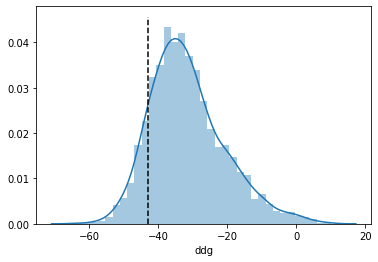

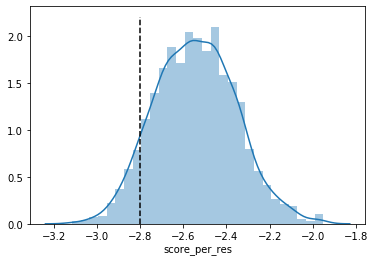

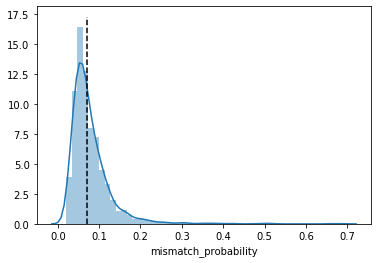

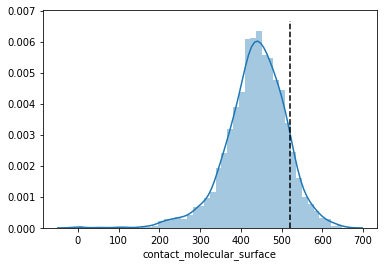

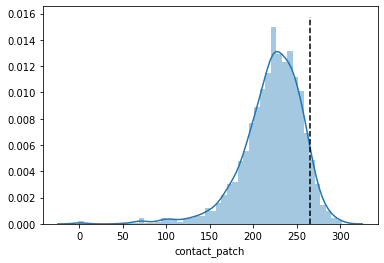

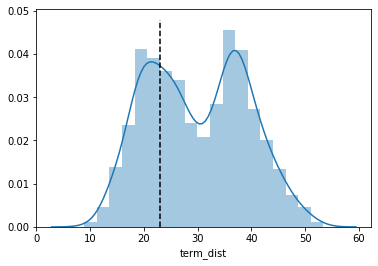

In [9]:
for term in terms_and_cuts:
    plt.figure()
    sns.distplot(pilot_df[term])
    x = terms_and_cuts[term][0]
    plt.plot([x,x],plt.ylim(),'k--')
    plt.show()

In [10]:
# Dump the tags for the Orderable designs from the pilot

with open("<path/to/desired>/pilot_orderable_tags.list", "w") as f:
    for idx, row in pilot_df[pilot_df['orderable']].iterrows():
        f.write("%s\n"%row['description'])

In [11]:
# Setup the Maximum Likelihood functions

eqs = []

def prob_of_1term(value, zdf, pilot_term, terms_and_cuts):
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    
    cut_div = cut + 0.01
    if (is_int):
        cut_div = 1
#     print(value)
    representatives = zdf[abs( (zdf[term] - value) / cut_div ) < 0.02]
    
    if ( good_high ):
        fail = (representatives[pilot_term] < cut).sum()
        ok = (representatives[pilot_term] >= cut).sum()
    else:
        fail = (representatives[pilot_term] > cut).sum()
        ok = (representatives[pilot_term] <= cut).sum()
        
    if (fail + ok < 5):
        return np.nan, 1
    return ok / (fail + ok), fail + ok


def get_low_high_bin_size_low_bin_num_bins(dfz, pilot_term, terms_and_cuts):
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    cut_div = cut + 0.01
    
    low = dfz[term].min()
    high = dfz[term].max()
    if (abs( (low - cut) / cut_div ) > 1000 ):
        print("Crazy value!!!", pilot_term, low, high)
        assert(False)
        
    bin_size = abs(cut_div * 0.02)
    
    if ( is_int ):
        bin_size = 1
    low_bin = math.floor( low / bin_size )

    num_bins = math.floor( high / bin_size ) - low_bin + 1
    
    return low, high, bin_size, low_bin, num_bins
    
# Find the index of xs that maximumizes the following equation
# np.sum( xs[:i] * flip < divisor ) + np.sum( xs[i:] * flip > divisor )
def find_ind_that_divides( divisor, array, flip ):
    best_sum = 0
    best_i = None
    for i in range(len(array)):
        value = np.sum( array[:i] * flip < flip * divisor ) + np.sum( array[i:] * flip > flip * divisor )
        if ( value > best_sum ):
            best_sum = value
            best_i = i
    return best_i
    
def sigmoid(x, a, b):
    return 1 / ( 1 + np.exp( -( x - a) * b ) )
def smooth_empty_prob_array(arr, good_high, counts, graphs=False, low=0, bin_size=0, gd=None, term=""):

    
    counts = list(counts)
    x = list(range(0, len(arr)))
    to_remove = []
    for i in range(len(arr)):
        if (math.isnan(arr[i])):
            to_remove.append(i)
    arr_copy = list(arr)
    for i in reversed(to_remove):
        x.pop(i)
        arr_copy.pop(i)
        counts.pop(i)
    arr_copy = np.array(arr_copy)

#     print(good_high)

    # We're trying to fit a sigmoid here. I've found that while the
    # function will often converge with a nonsense starting point
    # if you want it to be robust, you need to calculate the parameters
    # by hand first

    # The xguess is where the sigmoid crosses 0.5
    
    
    flip = 1 if good_high else -1
    
    never_high = max(arr_copy) < 0.5
    never_low = min(arr_copy) > 0.5
    
    # Your data is totally garbage
    if (never_high and never_low):
        xguess = x[int(len(x)/2)]
        
    # Your data is all below 0.5, assign xguess to edge
    elif ( never_high ):
        if ( good_high ):
            xguess = x[-1]
        else:
            xguess = x[0]
            
    # Your data is all above 0.5, assign xguess to edge
    elif (never_low):
        if ( good_high ):
            xguess = x[0]
        else:
            xguess = x[-1]
            
    else:
        # here we have full range data
        # pick x that maximizes the following function
        # np.sum( arr_copy[:x] < 0.5 ) + np.sum( arr_copy[x:] > 0.5 )
       
        best_ix = find_ind_that_divides(0.5, arr_copy, flip)
        xguess = x[best_ix]
        
            
    # Ok, now let's work on the slope guess
    # Formula is: guess = ln( 1 / y - 1) / ( xdist from 0.5 to y)
    # We'll use y = 0.2 and 0.8
    
    never_high = max(arr_copy) < 0.8
    never_low = min(arr_copy) > 0.2
    
    # Data never goes above 0.8, assign xvalue to edge
    if ( never_high ):
        if ( good_high ):
            ub = x[-1]
        else:
            lb = x[0]
    else:
    # Find xvalue that corresponds to graph crossing 0.8
        best_ix = find_ind_that_divides(0.8, arr_copy, flip)
        if ( good_high ):
            ub = x[best_ix]
        else:
            lb = x[best_ix]
        
    # Data never goes below 0.2, assign xvalue to edge
    if ( never_low ):
        if ( good_high ):
            lb = x[0]
        else:
            ub = x[-1]
    else:
    # Find xvalue that corresponds to graph crossing 0.2
        best_ix = find_ind_that_divides(0.2, arr_copy, flip)
        if ( good_high ):
            lb = x[best_ix]
        else:
            ub = x[best_ix]
            
    # One side of the data is bad, just use the other side
    if ( ub <= xguess ):
        ub = xguess - lb + xguess
    if ( lb >= xguess ):
        lb = xguess - ( ub - xguess )
    
    # The data is really bad here, just assign the ub and lb to the edges
    if ( ub == lb ):
        lb = x[0]
        ub = x[-1]
            
    # Average our two distances
    critical_dist = (( ub - xguess ) + (xguess - lb )) / 2
    
    # Find slope guess
    slope_guess = np.abs( np.log( 1 / 0.2 - 1) / critical_dist ) * flip
            
    # Curve fit
    popt, pcov = curve_fit( sigmoid, x, arr_copy, p0=(xguess, slope_guess), maxfev=100000, sigma=1/np.sqrt(counts) )
    
    # Uncomment this if you're debugging the guesses (They do really well tbh)
#     popt = (xguess, slope_guess)
    
    # Our new fitted data
    arr2 = sigmoid(np.arange(0, len(arr), 1), popt[0], popt[1])
    
    a_prime = popt[0]*bin_size+low
    b_prime = popt[1]/bin_size
    global eqs
    eqs.append( " 1 / ( 1 + EXP( -( %s - %.5f ) * %.5f ) ) "%(term[:-5], a_prime, b_prime))
    
    
    if (graphs):
        plt.figure(figsize=(5,3))
        sns.set(font_scale=1)
        plt.plot(np.arange(0, len(arr), 1)*bin_size+low, arr)
        plt.plot(np.arange(0, len(arr), 1)*bin_size+low, arr2)
        if (gd):
            plt.xlim([gd[0], gd[1]])
            plt.xlabel(gd[2])
            plt.axvline(gd[3], color='r')
        plt.ylabel("P( passing filter )")
        sns.set(font_scale=1.8)
        plt.show()
    
    for i in range(len(arr2)):
        arr[i] = arr2[i]
    
def create_prob_array(low, high, low_bin, num_bins, bin_size, pilot_term, dfz, terms_and_cuts, graphs=False):
    cut, good_high, term, is_int = terms_and_cuts[pilot_term]
    arr = np.zeros(num_bins)
    for i in range(len(arr)):
        arr[i] = np.nan
        
    counts = np.zeros(num_bins)
    counts.fill(1)

    print("%s from %.3f to %.3f"%(pilot_term, low, high))
    for val in np.arange(low, high + bin_size, bin_size/2):
        binn = math.floor( val / bin_size ) - low_bin
        if (binn >= len(arr)):
            continue
        if (is_int):
            val = round(val, 1)
#         print(val)
        prob, count = prob_of_1term(val, dfz, pilot_term, terms_and_cuts)
    
        counts[binn] = count + 1
        if ( math.isnan(prob)):
            pass
        else:
            arr[binn] = prob
            
    gd = None
    try:
        gd = graph_data[pilot_term]
    except:
        pass
    smooth_empty_prob_array(arr, good_high, counts, graphs, low, bin_size, gd, term)        
    
    return arr

def apply_prob_arrays(dfz, prob_arrays, prob_name):
    prob_terms = []
    for term in prob_arrays:
        print(term)
        arr, bin_size, low_bin = prob_arrays[term]
        prob_term = term + "_prob"
        idx = (np.floor(dfz[term] / bin_size) - low_bin).astype("int")
        is_low = (idx < 0)
        is_high = (idx >= len(arr) ).sum()
        low = np.min(idx)
        high = np.max(idx)
        
#         if (is_low.sum() > 0 or is_high.sum() > 0):
#             print("Warning: bounds overshoot on %s [%.3f, %.3f]"%
#                   (term, low_bin * bin_size, (low_bin + len(arr)) * bin_size))
#             print("Below: %i Below_median: %.3f Below_max: %.3f Above: %i Above_median: %.3f Above_max: %.3f"%(
#                 is_low.sum(), (0 - np.median(idx[is_low]))*bin_size, (0 - low)*bin_size,
#                 is_high.sum(), (np.median(idx[is_high]) - len(arr))*bin_size, (high-len(arr))*bin_size
#             ))
        
        idx = np.clip(idx, 0, len(arr)-1)
        dfz[prob_term] = arr[ idx ]
        prob_terms.append(prob_term)
    dfz[prob_name] = 1
    for prob_term in prob_terms:
        dfz[prob_name] *= dfz[prob_term]


        
    
def train_and_predict_mle(df, all_indices, test_indices, terms_and_cuts, prob_name, whole_df, graphs=False):

    use_indices = list(set(all_indices) - set(test_indices))

    test_df = df.iloc[test_indices].copy(True)
    use_df = df.iloc[use_indices].copy(True)

    
    prob_arrays = {}

    for pilot_term in terms_and_cuts:
        cut, good_high, term, is_int = terms_and_cuts[pilot_term]
        low, high, bin_size, low_bin, num_bins = get_low_high_bin_size_low_bin_num_bins(whole_df, pilot_term, terms_and_cuts)

#         print(len(use_df))
        prob_array = create_prob_array(low, high, low_bin, num_bins, bin_size, pilot_term, use_df, terms_and_cuts, graphs)

        prob_arrays[term] = (prob_array, bin_size, low_bin)
    
    
    apply_prob_arrays(test_df, prob_arrays, prob_name)
    
    return test_df[[prob_name, 'description']], prob_arrays


ddg from -70.803 to 19.847


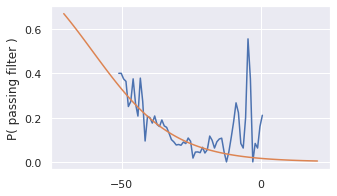

score_per_res from -3.479 to -0.003


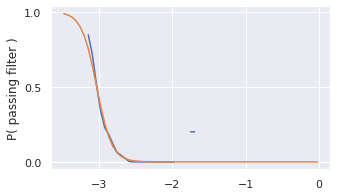

mismatch_probability from 0.013 to 0.764


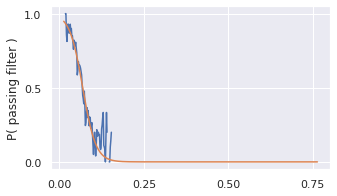

contact_molecular_surface from -1.000 to 657.211


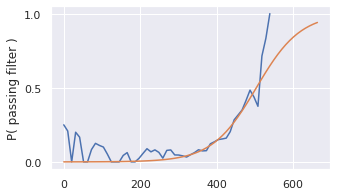

contact_patch from -1.000 to 330.980


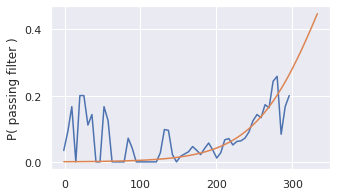

term_dist from 4.577 to 60.038


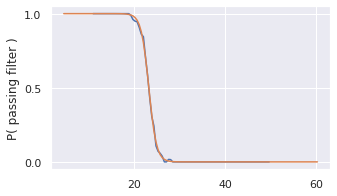

ddg_norepack_pred
score_per_res_pred
mismatch_probability_pred
contact_molecular_surface_pred
contact_patch_pred
term_dist_pred

-predictor_filters ddg_norepack,score_per_res,mismatch_probability,contact_molecular_surface,contact_patch,term_dist
-equation="- 1 / ( 1 + EXP( -( ddg_norepack - -60.46655 ) * -0.06830 ) ) * 1 / ( 1 + EXP( -( score_per_res - -3.02947 ) * -9.75875 ) ) * 1 / ( 1 + EXP( -( mismatch_probability - 0.06914 ) * -51.81542 ) ) * 1 / ( 1 + EXP( -( contact_molecular_surface - 504.34751 ) * 0.01721 ) ) * 1 / ( 1 + EXP( -( contact_patch - 342.54927 ) * 0.02200 ) ) * 1 / ( 1 + EXP( -( term_dist - 23.25530 ) * -1.19061 ) ) "


In [12]:
# This code is a little out-dated, but it still works
# We have the test_indices set to 0.1% because the curve fitting removes memorization

train_df = pilot_df.copy(True)
all_indices = list(range(len(train_df)))
test_indices = random.sample(range(len(train_df)), int(len(train_df)*0.001))

# This sets up maximum likihood method
not_used, prob_arrays = train_and_predict_mle(train_df, all_indices, test_indices, terms_and_cuts, "predict", predictor_df, True)

print("")
print('-predictor_filters ' + ",".join( terms_and_cuts[x][2][:-5] for x in list(terms_and_cuts)))
print('-equation="-' + "*".join(eqs) + '"')

ddg_norepack_pred
score_per_res_pred
mismatch_probability_pred
contact_molecular_surface_pred
contact_patch_pred
term_dist_pred


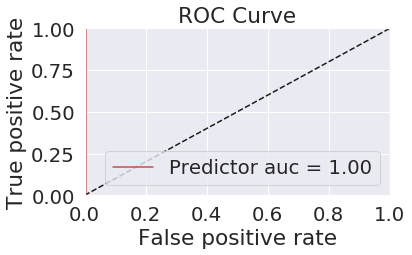

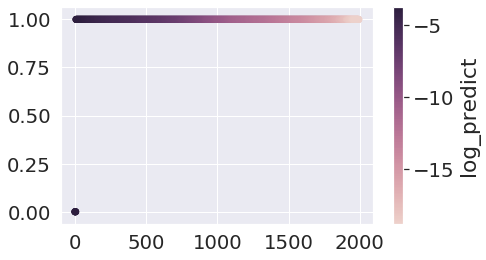

ddg_norepack_pred
score_per_res_pred
mismatch_probability_pred
contact_molecular_surface_pred
contact_patch_pred
term_dist_pred


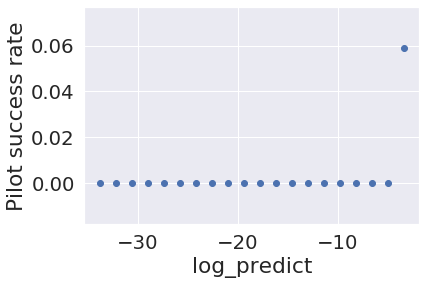

In [13]:
# Apply the mle method to the training set to get a feel for how well it worked

apply_prob_arrays(pilot_df, prob_arrays, "predict")
pilot_df['log_predict'] = np.log10(pilot_df['predict'])
plot_df = pilot_df
fpr,tpr,thresholds = roc_curve(plot_df["orderable"], plot_df["predict"])

fig, ax = plt.subplots(figsize=(6,4))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r', label = "Predictor auc = %.2f"%(auc(fpr, tpr)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.tight_layout()
plt.show()

# Make a cool graph to get a feel for where different predict values lie
df_c=pilot_df.sort_values("predict", ascending=False)
df_c['total_orderable'] = df_c['orderable'].cumsum()
df_c['log_predict'] = np.log10(df_c['predict'])


cmap = sns.cubehelix_palette(as_cmap=True)

lowb = np.percentile(df_c['log_predict'], 2)
upb = np.percentile(df_c['log_predict'], 98)
f, ax = plt.subplots(figsize=(7, 4))
points = ax.scatter(range(len(df_c)), df_c['total_orderable'], c=df_c['log_predict'], vmin=lowb,vmax=upb, cmap=cmap)
plt.setp(ax.get_xticklabels(), visible=True)
plt.setp(ax.get_yticklabels(), visible=True)
cb = f.colorbar(points)
cb.set_label("log_predict")

plt.show()

apply_prob_arrays(predictor_df, prob_arrays, "predict")
predictor_df['log_predict'] = np.log10(predictor_df['predict'])
minimum = predictor_df['log_predict'].min()
maximum = predictor_df['log_predict'].max()
steps = 20
step = (maximum - minimum)/steps
probability_mapping_x = np.arange(minimum, maximum, step)
probability_mapping_y = []

last_prob = None
for step_prob in probability_mapping_x:
    upper = step_prob + step
    total = pilot_df[(pilot_df['log_predict'] > step_prob) & (pilot_df['log_predict'] < upper)]
    orderable = total['orderable'].sum()
    if ( len(total) < 10 ):
        prob = last_prob
    else:
        prob = orderable / len(total)
    probability_mapping_y.append(prob)
    last_prob = prob
# fill in the beginning
last_prob = probability_mapping_y[-1]
for i in range(len(probability_mapping_y)):
    i = len(probability_mapping_y) - i - 1
    if ( probability_mapping_y[i] is None ):
        probability_mapping_y[i] = last_prob
    last_prob = probability_mapping_y[i]

probability_mapping_y = np.array(probability_mapping_y)
    
plt.xlabel("log_predict")
plt.ylabel("Pilot success rate")
plt.scatter(probability_mapping_x, probability_mapping_y)
plt.show()

ddg_norepack_pred
score_per_res_pred
mismatch_probability_pred
contact_molecular_surface_pred
contact_patch_pred
term_dist_pred


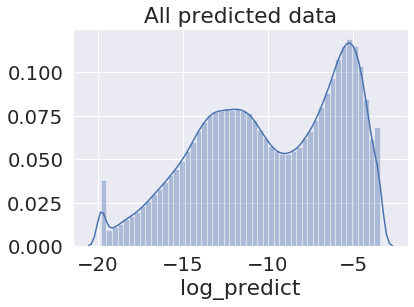

In [14]:
# Apply the mle to the predictor data and see how the values look

apply_prob_arrays(predictor_df, prob_arrays, "predict")
predictor_df['log_predict'] = np.log10(predictor_df['predict'])
bounds = (np.percentile(predictor_df['log_predict'], 1), np.percentile(predictor_df['log_predict'], 99))
sns.distplot(predictor_df['log_predict'].clip(bounds[0], bounds[1]))
plt.title("All predicted data")
plt.show()

In [15]:
#### Choose one of these two boxes!!!

## Choose this one if you want to continue with a set number of designs

# May 2020, Brian changed this to 500K which is more in line with what he actually does

number_to_design = 140000 # ~10% of total grafting outputs - recommended by Brian

# Don't change
number_to_design = min(number_to_design, len(predictor_df))
use_log_predict = -sorted(-predictor_df['log_predict'])[number_to_design-1]

In [65]:
#### Choose one of these two boxes!!!

## Choose this one if you want select how many based on the graphs above

use_log_predict = -2.8

# Don't change
number_to_design = (predictor_df['log_predict'] >= use_log_predict).sum()

In [16]:
## This will tell you the results of your choice

print("Planning to design: %i"%number_to_design)
print("Worst log_predict: %.1f"%(use_log_predict))
print("")
indices = (np.searchsorted(probability_mapping_x, 
                predictor_df[predictor_df['log_predict'] >= use_log_predict]['log_predict']) - 1).clip(0, None)
number_good = probability_mapping_y[indices].sum()
print("Predicted number of successful designs: %i"%( number_good ))

Planning to design: 140000
Worst log_predict: -4.7

Predicted number of successful designs: 738


In [17]:
# Write the selected tags to a file

good_df = predictor_df[predictor_df['log_predict'] >= use_log_predict]
with open("<path/to/desired>/predicted_fastdesign_tags.list", "w") as f:
    for idx, row in good_df.iterrows():
        f.write("%s\n"%row['description'][:-5])